Main task is create model for predict class of record
It's my second notebook, in the first got bed metrics and i redone data transform

In [35]:
import numpy as np
import pandas as pd

In [36]:
start_data = pd.read_parquet('train.parquet')

In [37]:
start_data.head()

,CompanyKey,ProfitLoss,AccountLocal,AccSide,AccountLocalCorr,Виды деятельности,Прочие доходы и расходы,Номенклатурные группы,Статьи затрат,Статьи ДДС,Amount,TargetKey,TargetName
0,BNV,0,01,Dt,08,,,,,,395599.24,24,Прочие Активы
1,BNV,0,08,Cr,01,,,,,,-395599.24,24,Прочие Активы
2,BNV,0,08,Dt,60,,,,,,395599.24,24,Прочие Активы
3,BNV,0,10,Cr,20,,,Основная номенклатурная группа,Списание материалов,,-12868.81,24,Прочие Активы
4,BNV,0,10,Cr,26,,,,почтовые расходы,,-81507.85,24,Прочие Активы


In [40]:
start_data.isnull().sum()

CompanyKey                    0
ProfitLoss                    0
AccountLocal                  0
AccSide                       0
AccountLocalCorr              0
Виды деятельности             0
Прочие доходы и расходы       0
Номенклатурные группы         0
Статьи затрат                 0
Статьи ДДС                    0
Amount                        0
TargetKey                  2510
TargetName                 2510
dtype: int64

In [42]:
 start_data.AccountLocal =start_data.AccountLocal.astype(float)

In [43]:
start_data.AccountLocalCorr = start_data.AccountLocalCorr.astype(float)

In [44]:
for col in start_data.columns:
    if (start_data[col].dtype!=str) & (start_data[col].dtype!=float):
        start_data[col] =start_data[col].astype(str)

In [47]:
str_col = [col  for col in start_data.columns if start_data[col].dtypes=='object']

In [48]:
str_data = start_data.loc[:, str_col]

In [49]:
str_data.head()

,CompanyKey,ProfitLoss,AccSide,Виды деятельности,Прочие доходы и расходы,Номенклатурные группы,Статьи затрат,Статьи ДДС,TargetKey,TargetName
0,BNV,0,Dt,,,,,,24,Прочие Активы
1,BNV,0,Cr,,,,,,24,Прочие Активы
2,BNV,0,Dt,,,,,,24,Прочие Активы
3,BNV,0,Cr,,,Основная номенклатурная группа,Списание материалов,,24,Прочие Активы
4,BNV,0,Cr,,,,почтовые расходы,,24,Прочие Активы


# Now i will transform str data to number
I wana convert all str data using one-hor-encoding, i will use tree models, may be this format data help make model better

In [50]:
start_data.CompanyKey.value_counts()

MLK    2102
VES    1172
MSS    1024
MPI     924
BNV     301
VIM     301
VMT     178
Name: CompanyKey, dtype: int64

In [51]:
start_data = pd.concat([start_data, pd.get_dummies(start_data.CompanyKey, prefix="Company_key")], axis=1)

In [52]:
start_data.drop('CompanyKey', axis=1, inplace=True)

In [53]:
start_data.ProfitLoss =start_data.ProfitLoss.astype(int)

In [54]:
AccSide_dict = {j:i for i, j in enumerate(start_data.AccSide.unique())}

In [55]:
start_data.AccSide=start_data.AccSide.map(AccSide_dict)

In [56]:
start_data.loc[start_data['Виды деятельности']=='' ,'Виды деятельности']='None'

In [63]:
agr_col = ['Виды деятельности','Прочие доходы и расходы','Номенклатурные группы','Статьи затрат','Статьи ДДС']

In [64]:
for col in agr_col:
    start_data.loc[start_data[col]=='', col]='None'

In [65]:
start_data.head()

,ProfitLoss,AccountLocal,AccSide,AccountLocalCorr,Виды деятельности,Прочие доходы и расходы,Номенклатурные группы,Статьи затрат,Статьи ДДС,Amount,TargetKey,TargetName,Company_key_BNV,Company_key_MLK,Company_key_MPI,Company_key_MSS,Company_key_VES,Company_key_VIM,Company_key_VMT
0,0,1.0,0,8.0,None,None,None,None,None,395599.24,24,Прочие Активы,1,0,0,0,0,0,0
1,0,8.0,1,1.0,None,None,None,None,None,-395599.24,24,Прочие Активы,1,0,0,0,0,0,0
2,0,8.0,0,60.0,None,None,None,None,None,395599.24,24,Прочие Активы,1,0,0,0,0,0,0
3,0,10.0,1,20.0,None,None,Основная номенклатурная группа,Списание материалов,None,-12868.81,24,Прочие Активы,1,0,0,0,0,0,0
4,0,10.0,1,26.0,None,None,None,почтовые расходы,None,-81507.85,24,Прочие Активы,1,0,0,0,0,0,0


In [148]:
start_data['text_col']= ""
for col in agr_col:
    start_data['text_col'] += start_data[col].map(lambda x: " "+x if x!="none" else "")

In [149]:
# Finction for drop marks and stop words in the text data
marks = '''!()-[]/{/};?@#$%:'"\,./^&amp;*_'''
stop_words = ['в','по', 'за','и','из','на','не','с','при', 'для','или',  'у', 'з', 'их',  'без', 'к','й', 'ii', 'vi',  'і','cr', '0']
def drop_marks_words(text):
    res_text = []
    text = text.lower()
    words = text.split()
    for word in words:
        for char in word:
            if char in marks:
                word = word.replace(char, "")
        res_text.append(word)
    for stop in stop_words:
        if stop in res_text:
            res_text.remove(stop)
    return " ".join(res_text)

In [150]:
start_data.loc[start_data.text_col =="", 'text_col'] = 'none'

In [151]:
start_data.text_col=  start_data.text_col.map(drop_marks_words)

In [152]:
start_data

,ProfitLoss,AccountLocal,AccSide,AccountLocalCorr,Виды деятельности,Прочие доходы и расходы,Номенклатурные группы,Статьи затрат,Статьи ДДС,Amount,TargetKey,TargetName,Company_key_BNV,Company_key_MLK,Company_key_MPI,Company_key_MSS,Company_key_VES,Company_key_VIM,Company_key_VMT,text_col
0,0,1.0,0,8.0,None,None,None,None,None,395599.24,24,Прочие Активы,1,0,0,0,0,0,0,none none none none none
1,0,8.0,1,1.0,None,None,None,None,None,-395599.24,24,Прочие Активы,1,0,0,0,0,0,0,none none none none none
2,0,8.0,0,60.0,None,None,None,None,None,395599.24,24,Прочие Активы,1,0,0,0,0,0,0,none none none none none
3,0,10.0,1,20.0,None,None,Основная номенклатурная группа,Списание материалов,None,-12868.81,24,Прочие Активы,1,0,0,0,0,0,0,none none основная номенклатурная группа списа...
4,0,10.0,1,26.0,None,None,None,почтовые расходы,None,-81507.85,24,Прочие Активы,1,0,0,0,0,0,0,none none none почтовые расходы none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5997,0,91.0,0,99.0,None,Проценты по займу,None,None,None,1853.61,nan,None,0,1,0,0,0,0,0,none проценты займу none none none
5998,0,91.0,0,99.0,None,Суммовые разницы,None,None,None,5125.71,nan,None,0,1,0,0,0,0,0,none суммовые разницы none none none
5999,1,732.0,1,311.0,None,None,None,None,Інші надходження коштів,-1822.43,nan,None,0,0,0,0,0,1,0,none none none none інші надходження коштів
6000,0,91.0,0,99.0,None,"Реализация долгосрочного актива, предназначенн...",None,None,None,13.33,nan,None,0,1,0,0,0,0,0,none реализация долгосрочного актива предназна...


In [153]:
best_data = start_data.copy()

In [154]:
best_data.drop(agr_col, axis=1, inplace=True)

For transorm text data i used CountVectorizer

In [155]:
from sklearn.feature_extraction.text import CountVectorizer

In [156]:
count_vect = CountVectorizer()

In [157]:
count_vect.fit(best_data.text_col)

CountVectorizer()

In [158]:
res_col = count_vect.transform(best_data.text_col)

In [159]:
values =  res_col.toarray()
columns = count_vect.get_feature_names()

/home/uladzimir/anaconda3/envs/biv_arr/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [160]:
df_dict = {val: values[:, num] for num, val in enumerate(columns)}

In [161]:
prom_df = pd.DataFrame(df_dict)

In [162]:
finish_df = pd.concat([best_data, prom_df], axis=1)

In [163]:
finish_df.drop(['text_col', 'TargetName'], axis=1, inplace=True)

In [164]:
train_data = finish_df.loc[finish_df.TargetKey!=None, :]

In [165]:
 train_data.TargetKey= train_data.TargetKey.astype(str)

In [166]:
train_data = train_data.loc[train_data.TargetKey!='nan',:]

In [167]:
train_data.TargetKey= train_data.TargetKey.astype(int)

In [168]:
X = train_data.drop('TargetKey', axis=1)
y = train_data.TargetKey

In [169]:
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

For train model i sellected records

In [224]:
target_ser =train_data.TargetKey.value_counts()

In [225]:
df_target = pd.DataFrame(target_ser)

In [226]:
nes_target = df_target[df_target.TargetKey>5].index.values

In [227]:
train_data  =train_data.loc[train_data.TargetKey.isin( nes_target),:]

In [228]:
train_data.head()

,ProfitLoss,AccountLocal,AccSide,AccountLocalCorr,Amount,TargetKey,Company_key_BNV,Company_key_MLK,Company_key_MPI,Company_key_MSS,...,юр,юридическая,юридические,юридическим,юридического,юрлица,ємне,інформаційні,інших,інші
0,0,1.0,0,8.0,395599.24,24,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,8.0,1,1.0,-395599.24,24,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,8.0,0,60.0,395599.24,24,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,10.0,1,20.0,-12868.81,24,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,10.0,1,26.0,-81507.85,24,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [229]:
X = train_data.drop('TargetKey', axis=1)
y = train_data.TargetKey

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In the last notebook i have testes other models, and the best is DecisionTreeClassifier()

In [230]:
dec_tree = DecisionTreeClassifier()

In [231]:
train_data

,ProfitLoss,AccountLocal,AccSide,AccountLocalCorr,Amount,TargetKey,Company_key_BNV,Company_key_MLK,Company_key_MPI,Company_key_MSS,...,юр,юридическая,юридические,юридическим,юридического,юрлица,ємне,інформаційні,інших,інші
0,0,1.0,0,8.0,395599.24,24,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,8.0,1,1.0,-395599.24,24,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,8.0,0,60.0,395599.24,24,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,10.0,1,20.0,-12868.81,24,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,10.0,1,26.0,-81507.85,24,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3904,1,91.0,0,67.0,4746.66,92,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3910,1,91.0,0,68.0,5.40,133,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3911,1,91.0,0,68.0,41.60,133,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3912,1,91.0,0,68.0,1666.67,133,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [232]:
dec_tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [233]:
dec_tree.score(X_test, y_test)

0.9534883720930233

In [234]:
feature_imp =  dec_tree.feature_importances_ 

In [235]:
len(feature_imp)

922

In [236]:
drop_ind = [num for num, val in enumerate(feature_imp) if val<0.001]

In [237]:
len(drop_ind)

877

In [238]:
drop_columns = [X_train.columns[i] for i in drop_ind]

In [239]:
train_data_2 = train_data.copy()

In [240]:
train_data_2.drop(drop_columns, axis=1, inplace=True)

In [241]:
X = train_data_2.drop('TargetKey', axis=1)
y = train_data_2.TargetKey

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=30, stratify=y)

In [260]:
dec_tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [261]:
dec_tree.score(X_test, y_test)

0.9331395348837209

Now i tried tiune my model using RandomizedSearchCV, for finding best patamets

In [245]:
from sklearn.model_selection import RandomizedSearchCV

In [268]:
params = {
    'max_depth': [60, 120, 240, 360],
    'min_samples_leaf': [5, 10, 20, 50, 100, 150, 250],
    'criterion': ["gini", "entropy"]
}

In [269]:
random_search = RandomizedSearchCV(estimator=DecisionTreeClassifier(), 
                          param_distributions=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [270]:
random_search.fit(X_train, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


RandomizedSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [60, 120, 240, 360],
                                        'min_samples_leaf': [5, 10, 20, 50, 100,
                                                             150, 250]},
                   scoring='accuracy', verbose=1)

In [271]:
random_search.best_params_

{'min_samples_leaf': 5, 'max_depth': 120, 'criterion': 'gini'}

In [272]:
random_search.score(X_test, y_test)

0.9253875968992248

Now i wanna show the model score for each attribute

In [252]:
unic_y= y_test.unique()
df_y_test = pd.DataFrame(y_test)

In [253]:
index_dict = {}
for unic in unic_y:
    index_dict[unic]  = df_y_test[df_y_test.TargetKey==unic].index

In [254]:
pred_dict ={}
for y_val, y_index in zip(index_dict.keys(), index_dict.values()):
    X_for_pred=X_test[X_test.index.isin(y_index)]
    pred = dec_tree.predict(X_for_pred)
    pred_dict[y_val] = pred

In [255]:
metrics_dict ={}
for y_true, y_pred in zip(pred_dict.keys(), pred_dict.values()):
    res = list(y_pred).count(y_true)
    metrics_dict[y_true] = res/len(y_pred)

In [273]:
metrics_dict

{29: 1.0,
 35: 1.0,
 24: 0.9819819819819819,
 4: 0.9928057553956835,
 136: 0.5,
 78: 0.815068493150685,
 132: 0.8333333333333334,
 154: 0.5,
 147: 0.75,
 6: 1.0,
 157: 0.6,
 164: 0.75,
 127: 1.0,
 38: 0.8666666666666667,
 169: 0.9354838709677419,
 148: 1.0,
 170: 1.0,
 106: 0.9090909090909091,
 45: 1.0,
 9: 1.0,
 92: 0.8823529411764706,
 129: 0.6666666666666666,
 133: 0.6666666666666666,
 137: 1.0,
 89: 0.8,
 119: 1.0,
 61: 0.9285714285714286,
 79: 1.0,
 145: 0.5,
 146: 0.0,
 134: 0.3333333333333333,
 155: 0.3333333333333333,
 131: 0.5,
 171: 0.0,
 114: 0.4,
 123: 1.0,
 117: 1.0,
 138: 0.6666666666666666,
 56: 0.5,
 121: 0.6666666666666666}

In [274]:
 for_plot_len = [len(i) for i in pred_dict.values()]

Text(0.5, 1.0, 'Dependens score and quantoty of examples')

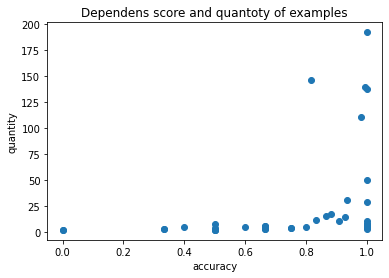

In [275]:
plt.scatter(list(metrics_dict.values()), for_plot_len)
plt.xlabel('accuracy')
plt.ylabel('quantity')
plt.title('Dependens score and quantoty of examples')

In this graph, we see the dependence of the prediction accuracy on the number of examples of this class. For this data and task, the DecisionTreeClassifier model is best suited. We can improve the metric of our model by constructing new features.

In [277]:
np.mean(list(metrics_dict.values()))

0.7569672178417057